# Group 5

### Date Feb 18, 2021

### Importing Important Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading the Data

In [2]:
weather = pd.read_csv('/content/drive/MyDrive/ASEC hackathon/ASEC 2021 Hackathon Information folder/weather_features.csv')

In [3]:
energy = pd.read_csv('/content/drive/MyDrive/ASEC hackathon/ASEC 2021 Hackathon Information folder/energy_dataset.csv')

### EDA and Data cleaning

In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [5]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [6]:
energy.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [7]:
energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [8]:
## deleating all day ahaead and value= 0 features
energy = energy.drop(['forecast wind offshore eday ahead', 'forecast solar day ahead','forecast wind onshore day ahead','generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation hydro pumped storage aggregated','generation marine','generation wind offshore','forecast wind offshore eday ahead'],axis=1)

In [9]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [10]:
## Filling the NaN value by bfill
energy = energy.fillna(method = 'bfill')

In [11]:
energy.isnull().sum()

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [12]:
# converting date to date time
energy['time'] = pd.to_datetime(energy['time'], utc=True, infer_datetime_format=True)
energy = energy.set_index('time')

In [13]:
energy.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,26118,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24934,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,23515,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,22642,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,21785,20264.0,38.41,56.04


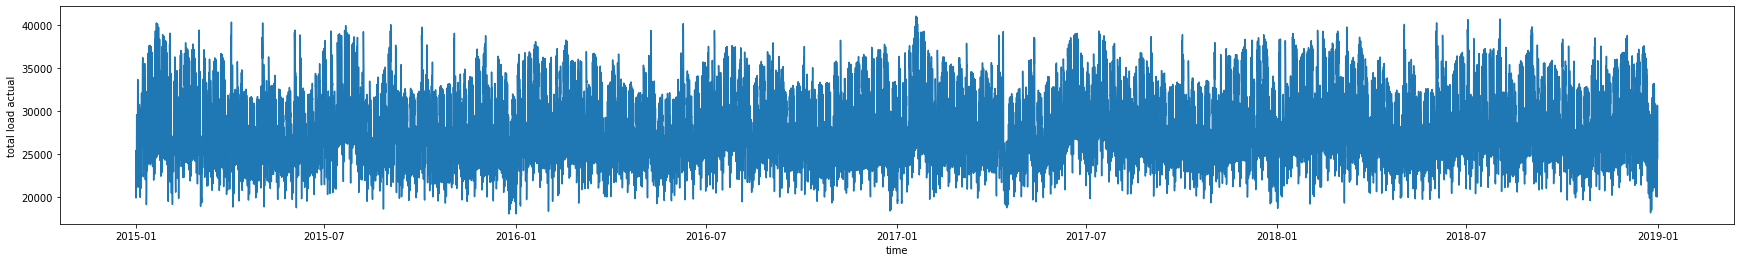

In [14]:
## plotting actual load with time
plt.figure(figsize=(30,4))
sns.lineplot(x= 'time',y='total load actual',data=energy)

In [15]:
## comparing by renewable and non renewable generation
energy['Total_nonrenewable'] = energy['generation fossil brown coal/lignite']+energy['generation fossil hard coal']+energy['generation fossil gas']+energy['generation fossil oil']+energy['generation other']
energy['Total_renewable'] =energy['generation biomass']+ energy['generation hydro pumped storage consumption']+energy['generation hydro run-of-river and poundage']+energy['generation hydro water reservoir']+ energy['generation nuclear']+energy['generation other renewable']+energy['generation solar']+energy['generation waste']+energy['generation wind onshore']

In [16]:
energy['Total produced'] = energy['Total_nonrenewable'] +energy['Total_renewable']

In [17]:
energy['fraction_renewable'] = energy['Total_renewable']/energy['Total produced'] 
energy['fraction_nonrenewable'] = energy['Total_nonrenewable']/energy['Total produced'] 

In [18]:
energy[['Total_nonrenewable','Total_renewable','fraction_renewable','fraction_nonrenewable']].describe()

,Total_nonrenewable,Total_renewable,fraction_renewable,fraction_nonrenewable
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,10685.874943,17953.095853,0.627143,0.372857
std,3942.864539,4327.683273,0.119244,0.119244
min,2761.000000,0.000000,0.000000,0.087804
25%,7453.000000,14781.750000,0.537130,0.278180
50%,10483.000000,17444.000000,0.613633,0.386367
75%,13362.250000,20643.000000,0.721820,0.462870
max,28142.000000,34062.000000,0.912196,1.000000


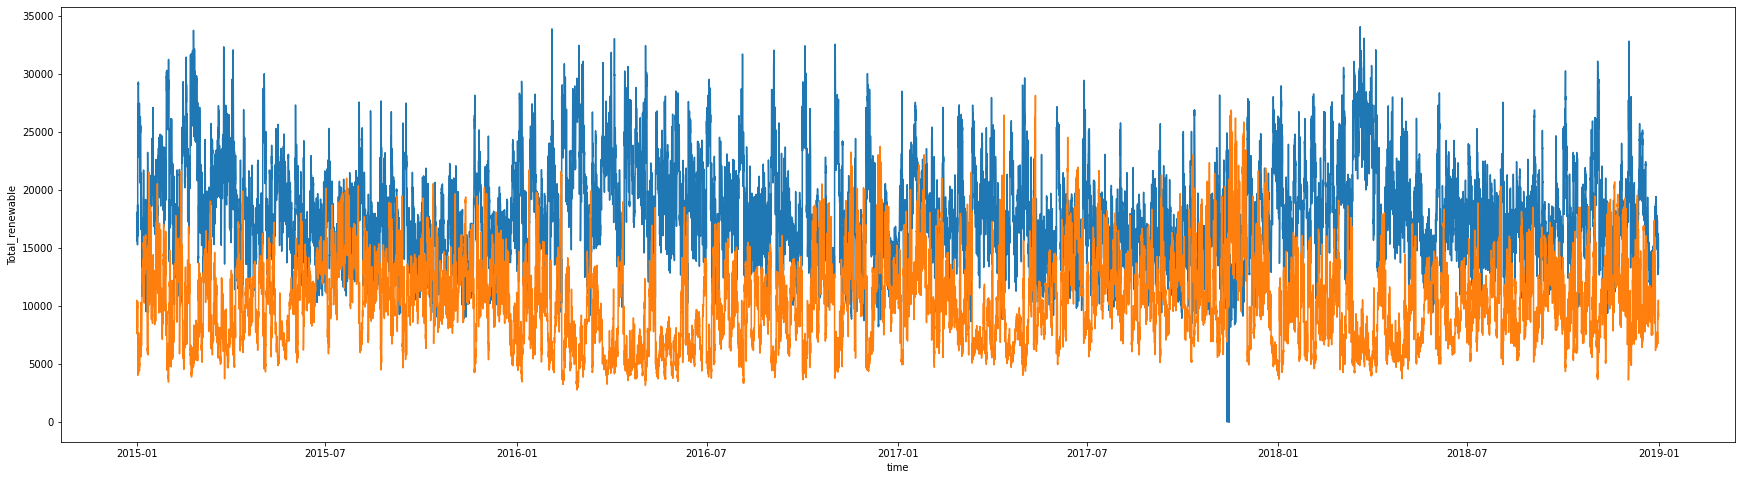

In [19]:
plt.figure(figsize=(30,8))
sns.lineplot(x= 'time',y='Total_renewable',data=energy)
sns.lineplot(x= 'time',y='Total_nonrenewable',data=energy)


In [20]:
## Fraction of total produced energy consumed
energy['Consumed energy fraction'] = energy['total load actual']/energy['Total produced']

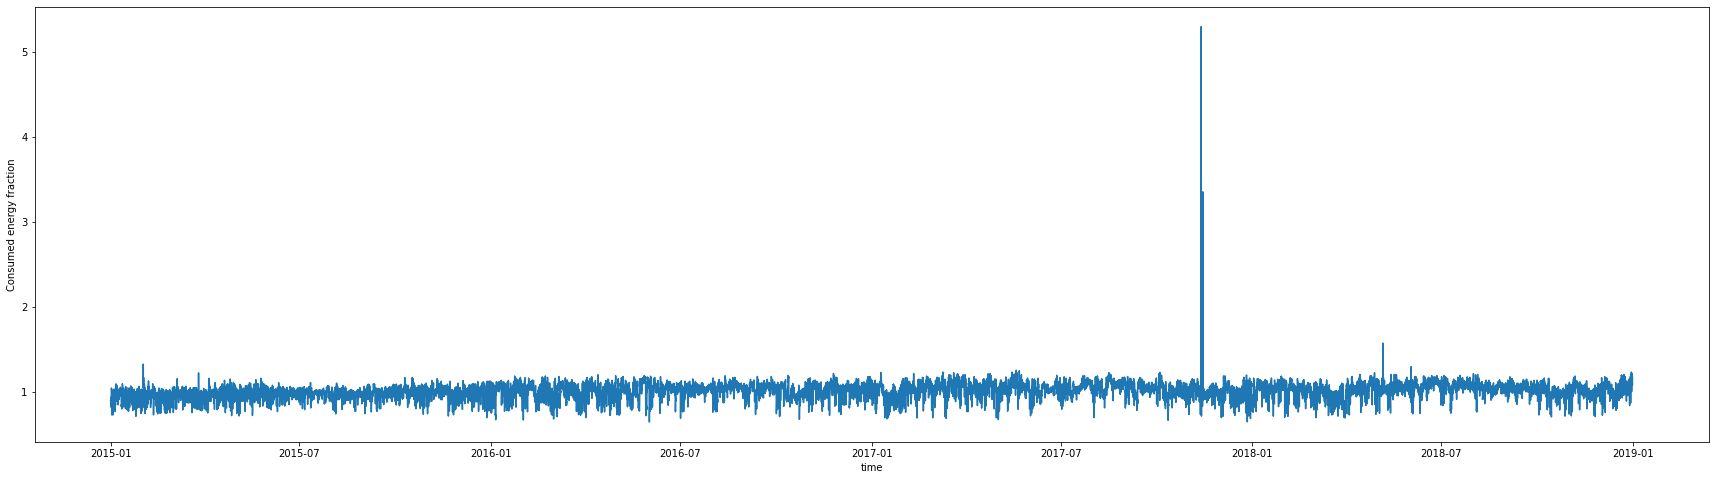

In [21]:
plt.figure(figsize=(30,8))
sns.lineplot(x= 'time',y='Consumed energy fraction',data=energy)

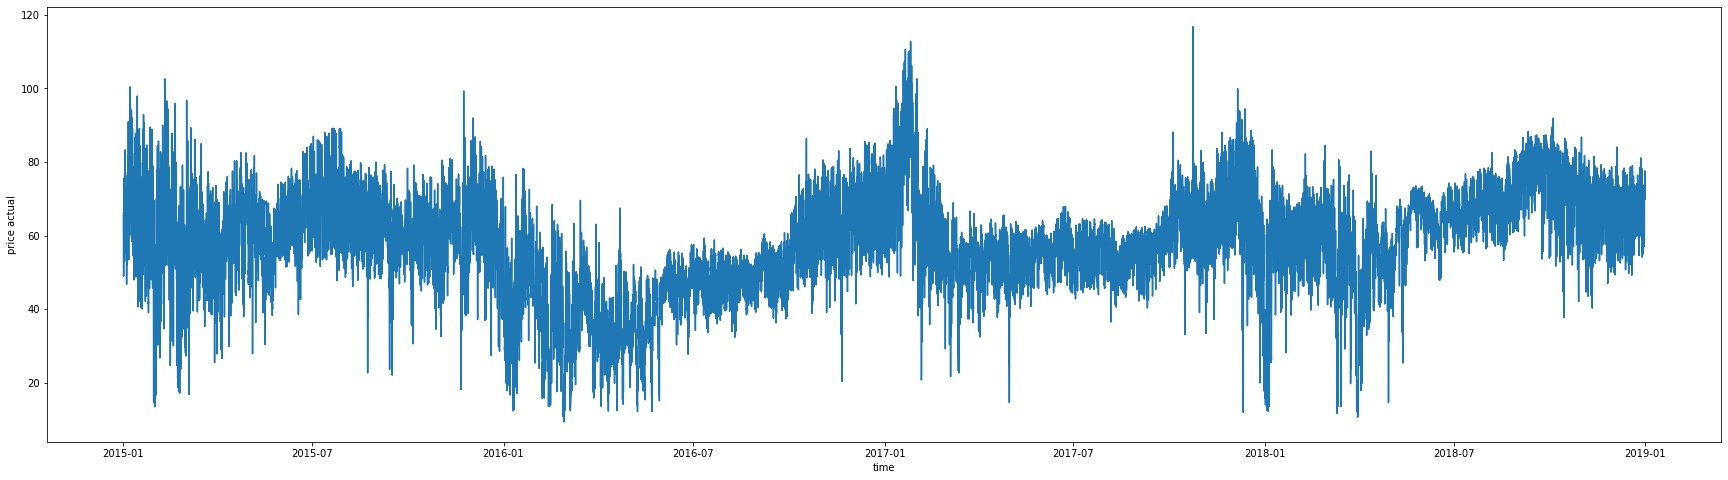

In [22]:
plt.figure(figsize=(30,8))
sns.lineplot(x= 'time',y='price actual',data=energy)

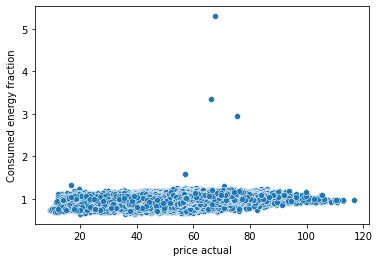

In [23]:
sns.scatterplot(x= 'price actual',y='Consumed energy fraction',data=energy)
## we see prices increase if load is more than produced

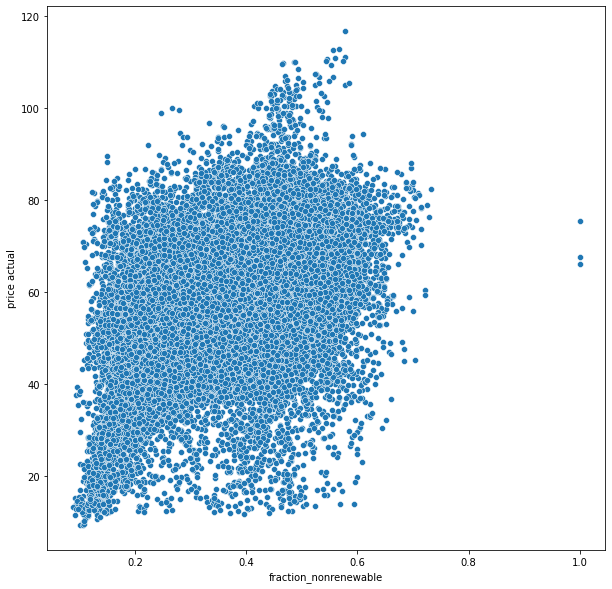

In [24]:
## Actual price variation with nonrenewable production
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'fraction_nonrenewable',y='price actual',data=energy)

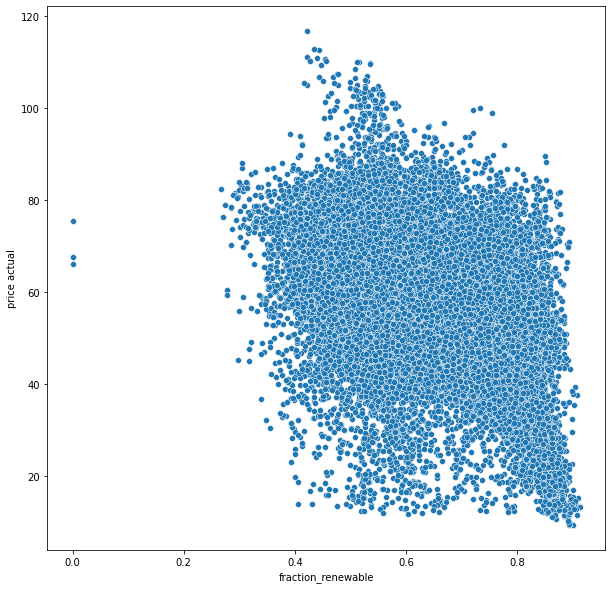

In [25]:
## actual price with renewable fraction production
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'fraction_renewable',y='price actual',data=energy)


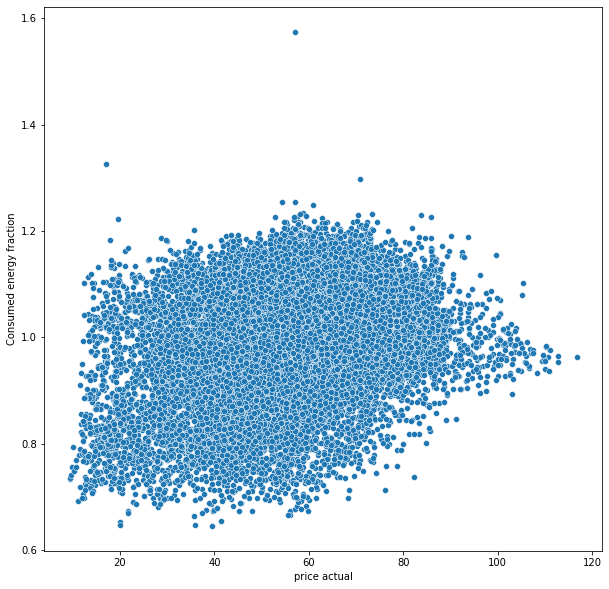

In [26]:
## actual price with consumed energy/total produced
df_comsumed_frac_2 = energy[energy['Consumed energy fraction']<2]
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'price actual',y='Consumed energy fraction',data=df_comsumed_frac_2)

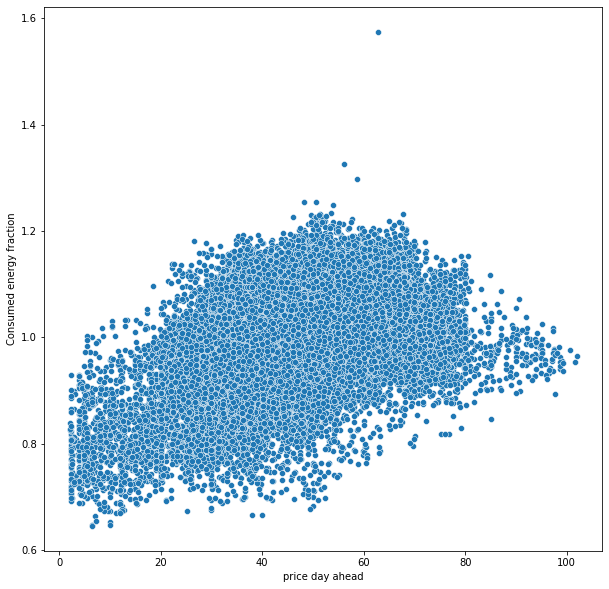

In [27]:
##  price day ahaead with consumed energy/total produced
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'price day ahead',y='Consumed energy fraction',data=df_comsumed_frac_2)

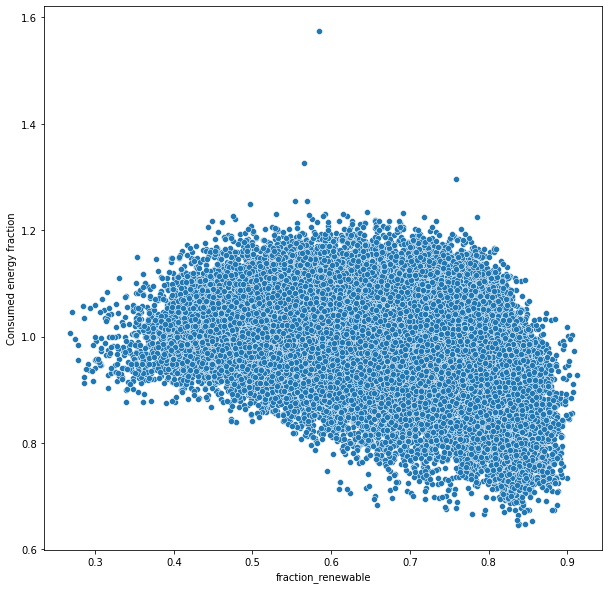

In [28]:
## consumed energy fraction vs renewable energy production
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'fraction_renewable',y='Consumed energy fraction',data=df_comsumed_frac_2)

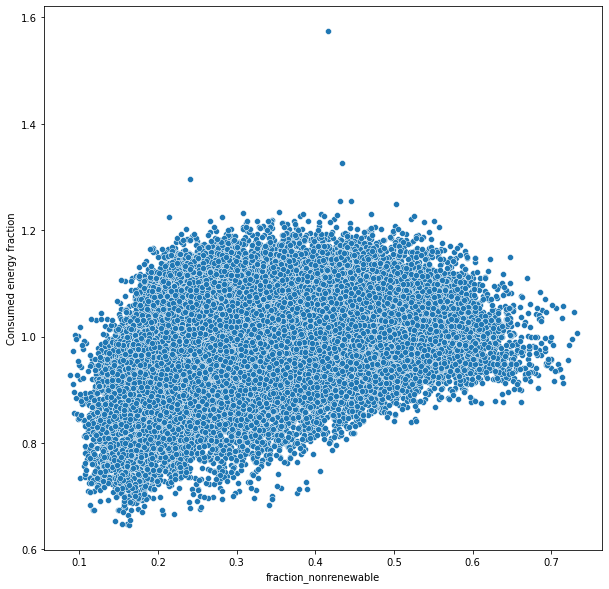

In [29]:
## consumed energy fraction vs non-renewable energy production
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'fraction_nonrenewable',y='Consumed energy fraction',data=df_comsumed_frac_2)

### weather dataset

In [30]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [31]:
weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [32]:
# Converting the date format
weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True, infer_datetime_format=True)
weather = weather.drop(['dt_iso'], axis=1)
weather = weather.set_index('time')

In [33]:
## As weather dataset contains 5 cities, we have to make 5 dataframe
## checking duplicates 
print('Total number of duplicates rows are {}' . format(weather.duplicated().sum()))

Total number of duplicates rows are 8622


In [34]:

mean_city = weather.groupby('city_name').mean()
mean_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [35]:
row_city = weather.groupby('city_name').count()

In [36]:
row_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
city_name,,,,,,,,,,,,,,,
Barcelona,35476,35476,35476,35476,35476,35476,35476,35476,35476,35476,35476,35476,35476,35476,35476
Bilbao,35951,35951,35951,35951,35951,35951,35951,35951,35951,35951,35951,35951,35951,35951,35951
Madrid,36267,36267,36267,36267,36267,36267,36267,36267,36267,36267,36267,36267,36267,36267,36267
Seville,35557,35557,35557,35557,35557,35557,35557,35557,35557,35557,35557,35557,35557,35557,35557
Valencia,35145,35145,35145,35145,35145,35145,35145,35145,35145,35145,35145,35145,35145,35145,35145


In [37]:
### we should have 35064 rows in each city as per the energy dataset, hence each city may have duplicates
## dropping duplicates canbe done using time and city name
weather = weather.reset_index().drop_duplicates(subset=['time', 'city_name'],keep='first')
weather  =weather.set_index('time')

In [38]:
row_city = weather.groupby('city_name').count()

In [39]:
## we can see that now the row for each city is equal to energy dataset
row_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
city_name,,,,,,,,,,,,,,,
Barcelona,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Bilbao,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Madrid,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Seville,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Valencia,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064


In [40]:
!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-s_y9eu9d
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-s_y9eu9d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 6.8MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-cp36-none-any.whl size=57891 sha256=1d29b8685521889c89d167919f7319d0ee69d382b5fa28535a0864a72da1082a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8m7ahf_s/wheels/5a/29/25/58347b486c135e3aaa41f629bace08cfb3e92d08c65d2b4acf
Successfully built neuralprophet
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [41]:

weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [42]:
## changing to celcius
weather['temp'] = weather['temp']-273.15
weather['temp_min']=weather['temp_min']-273.15
weather['temp_max']=weather['temp_max']-273.15

In [43]:
# describing some categorical features
weather.groupby('weather_description').mean()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
weather_description,,,,,,,,,,,,
broken clouds,14.693939,13.574940,15.928935,1027.483178,78.160028,2.444948,168.698000,0.000000,0.001076,0.000007,73.243136,803.0
drizzle,13.350749,11.693084,15.101542,1014.859031,89.189427,2.991189,170.101322,0.101762,0.000000,0.000000,71.792952,301.0
dust,25.165968,19.977419,33.183871,1015.780645,61.500000,2.206452,158.787097,0.000000,0.000000,0.000000,12.683871,761.0
few clouds,18.377634,17.071601,19.703281,1021.635316,63.985233,3.047198,172.871024,0.000071,0.000320,0.000000,19.692981,801.0
fog,8.444919,5.993632,11.511365,1023.570610,92.624283,1.317353,108.091193,0.001563,0.000000,0.000000,42.809276,741.0
haze,16.624924,12.582538,22.339518,1018.868020,76.893401,2.005076,127.974619,0.002284,0.000000,0.000000,19.817259,721.0
heavy intensity drizzle,13.753636,12.363636,15.606364,1016.181818,90.909091,3.090909,186.363636,0.136364,0.000000,0.000000,76.545455,302.0
heavy intensity rain,14.913376,13.128784,16.536010,1013.494293,85.610184,3.125549,217.127305,3.000000,0.000000,0.108980,55.038630,502.0
heavy intensity shower rain,14.361111,12.856250,16.235556,1011.027778,88.083333,4.416667,214.986111,3.000000,0.000000,0.000000,71.652778,522.0


In [44]:
weather.groupby('weather_id').mean() ## does not give any information specifically

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
weather_id,,,,,,,,,,,
200,18.117945,16.377671,20.502192,1013.904110,79.424658,3.000000,181.890411,0.028767,0.000000,0.000000,48.000000
201,17.408523,15.828409,19.064432,1014.125000,84.659091,3.602273,175.443182,0.057955,0.000000,0.000000,59.284091
202,18.194400,16.716000,19.697600,1014.440000,85.960000,4.640000,196.800000,0.000000,0.000000,0.000000,59.000000
210,27.790000,27.000000,29.000000,1013.000000,51.000000,2.000000,210.000000,0.900000,0.000000,0.000000,20.000000
211,20.522908,19.023793,21.985272,1014.113946,72.914966,3.200680,167.045918,0.250000,0.000000,0.000000,49.841837
300,13.440173,12.157506,14.903799,1014.561201,87.315242,2.793303,168.474596,0.091109,0.000000,0.000000,69.039261
301,13.368603,11.721965,15.109389,1014.903930,89.227074,2.995633,169.751092,0.100873,0.000000,0.000000,71.943231
302,13.753636,12.363636,15.606364,1016.181818,90.909091,3.090909,186.363636,0.136364,0.000000,0.000000,76.545455
310,13.718333,12.092593,15.853889,1020.462963,94.666667,2.277778,193.259259,0.044444,0.000000,0.000000,76.851852


In [45]:
weather.groupby('weather_main').mean() # as categories are less and descriptive

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
weather_main,,,,,,,,,,,,
clear,17.596993,16.287719,19.167786,1058.828608,61.267425,2.200012,162.722656,0.000003,0.000210,0.000002,0.309387,800.000000
clouds,16.735254,15.532935,18.001631,1060.748758,69.797899,2.798354,170.675753,0.000034,0.000739,0.000008,40.715121,801.859956
drizzle,13.447123,12.072962,15.008102,1014.981277,88.175319,2.802553,170.301277,0.092426,0.000000,0.000000,70.131915,300.813617
dust,25.070353,19.913462,33.038462,1015.817308,61.746795,2.227564,158.153846,0.000000,0.000000,0.000000,13.083333,760.807692
fog,8.444919,5.993632,11.511365,1023.570610,92.624283,1.317353,108.091193,0.001563,0.000000,0.000000,42.809276,741.000000
haze,16.624924,12.582538,22.339518,1018.868020,76.893401,2.005076,127.974619,0.002284,0.000000,0.000000,19.817259,721.000000
mist,10.518657,8.790912,12.675670,1021.784967,91.725817,1.463725,140.424837,0.015588,0.000000,0.000000,45.998366,701.000000
rain,12.782962,11.711178,13.985603,1188.108069,85.049383,2.745393,182.939345,0.705207,0.000000,0.048614,65.739906,502.135087
smoke,20.714242,18.333333,24.333333,1015.545455,64.303030,2.090909,161.515152,0.000000,0.000000,0.000000,20.121212,711.000000


In [46]:
## Removing some unneccesary categorical columns
weather = weather.drop(['weather_id', 
                              'weather_description', 'weather_icon','weather_main'], axis=1)

In [47]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city_name   175320 non-null  object 
 1   temp        175320 non-null  float64
 2   temp_min    175320 non-null  float64
 3   temp_max    175320 non-null  float64
 4   pressure    175320 non-null  int64  
 5   humidity    175320 non-null  int64  
 6   wind_speed  175320 non-null  int64  
 7   wind_deg    175320 non-null  int64  
 8   rain_1h     175320 non-null  float64
 9   rain_3h     175320 non-null  float64
 10  snow_3h     175320 non-null  float64
 11  clouds_all  175320 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 17.4+ MB


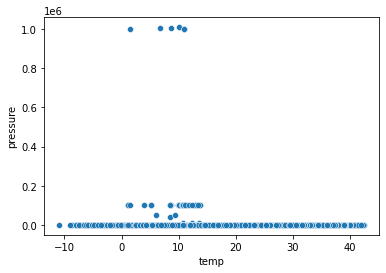

In [48]:
## Outliers replacement
sns.scatterplot(x= 'temp',y= 'pressure',data=weather)

In [49]:
weather[weather['pressure']> 1050] ## we can see some outleirs approx 412

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,
2016-07-21 19:00:00+00:00,Valencia,25.79,25.56,26.11,1073,41,3,107,0.0,0.0,0.0,0
2016-08-03 15:00:00+00:00,Valencia,35.19,29.60,38.89,1075,46,1,292,0.0,0.0,0.0,32
2016-08-03 16:00:00+00:00,Valencia,32.16,29.60,33.33,1074,45,1,315,0.0,0.0,0.0,8
2016-08-03 17:00:00+00:00,Valencia,31.40,29.40,32.22,1073,47,0,180,0.0,0.0,0.0,20
2016-08-03 18:00:00+00:00,Valencia,29.79,28.50,30.56,1074,47,1,135,0.0,0.0,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-22 09:00:00+00:00,Barcelona,10.71,10.71,10.71,10029,0,1,67,0.0,0.0,0.0,0
2015-02-22 10:00:00+00:00,Barcelona,11.90,11.90,11.90,100304,0,6,67,0.0,0.0,0.0,0
2015-02-22 11:00:00+00:00,Barcelona,12.30,12.30,12.30,100242,0,7,337,0.0,0.0,0.0,0


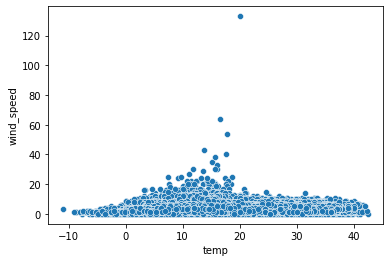

In [50]:
sns.scatterplot(x= 'temp',y= 'wind_speed',data=weather) ## remove > 40

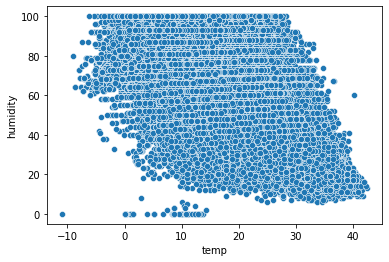

In [51]:
sns.scatterplot(x= 'temp',y= 'humidity',data=weather) ## no significant outliers

In [52]:
## outliers removal
weather.loc[weather['pressure'] > 1050, 'pressure'] = np.nan
weather.loc[weather['pressure'] < 950, 'pressure'] = np.nan

In [53]:
weather.loc[weather['wind_speed']> 40, 'wind_speed'] = np.nan

In [54]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city_name   175320 non-null  object 
 1   temp        175320 non-null  float64
 2   temp_min    175320 non-null  float64
 3   temp_max    175320 non-null  float64
 4   pressure    174233 non-null  float64
 5   humidity    175320 non-null  int64  
 6   wind_speed  175316 non-null  float64
 7   wind_deg    175320 non-null  int64  
 8   rain_1h     175320 non-null  float64
 9   rain_3h     175320 non-null  float64
 10  snow_3h     175320 non-null  float64
 11  clouds_all  175320 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 17.4+ MB


In [55]:
## by time interpolation of outliers replaced by Nan
weather.interpolate(method ='time',limit_direction='forward', inplace=True, axis=0)

In [56]:

weather.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,175320.0,16.557651,8.024910,-10.91,10.680000,16.0,22.09,42.450
temp_min,175320.0,15.278433,7.948249,-10.91,9.634586,15.0,21.00,42.000
temp_max,175320.0,18.022255,8.613916,-10.91,11.759258,17.0,24.00,48.000
pressure,175320.0,1016.346264,11.317985,950.00,1013.000000,1018.0,1022.00,1048.000
humidity,175320.0,68.032307,21.838097,0.00,53.000000,72.0,87.00,100.000
wind_speed,175320.0,2.468435,2.060739,0.00,1.000000,2.0,4.00,40.000
wind_deg,175320.0,166.724909,116.548788,0.00,56.000000,178.0,270.00,360.000
rain_1h,175320.0,0.069308,0.385915,0.00,0.000000,0.0,0.00,12.000
rain_3h,175320.0,0.000386,0.007348,0.00,0.000000,0.0,0.00,2.315
snow_3h,175320.0,0.004846,0.224547,0.00,0.000000,0.0,0.00,21.500


In [57]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city_name   175320 non-null  object 
 1   temp        175320 non-null  float64
 2   temp_min    175320 non-null  float64
 3   temp_max    175320 non-null  float64
 4   pressure    175320 non-null  float64
 5   humidity    175320 non-null  int64  
 6   wind_speed  175320 non-null  float64
 7   wind_deg    175320 non-null  int64  
 8   rain_1h     175320 non-null  float64
 9   rain_3h     175320 non-null  float64
 10  snow_3h     175320 non-null  float64
 11  clouds_all  175320 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 17.4+ MB


In [58]:
weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [59]:
## dataframes by cities
weather_Valencia=weather[weather['city_name'] == 'Valencia']
weather_Madrid=weather[weather['city_name'] == 'Madrid']
weather_Bilbao=weather[weather['city_name'] == 'Bilbao']
weather_Barcelona=weather[weather['city_name'] == ' Barcelona']
weather_Seville=weather[weather['city_name'] == 'Seville']

In [60]:
dfs = [weather_Valencia,weather_Barcelona,weather_Bilbao,weather_Madrid,weather_Seville]


In [61]:
## merging

energy_final = energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    energy_final  = energy_final .merge(df, on=['time'], how='outer')
    energy_final  = energy_final .drop('city_name_{}'.format(city_str), axis=1)
    

In [62]:
energy_final 

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual,Total_nonrenewable,Total_renewable,Total produced,fraction_renewable,fraction_nonrenewable,Consumed energy fraction,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,rain_3h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,26118,25385.0,50.10,65.41,10199.0,18052.0,28251.0,0.638986,0.361014,0.898552,-2.675,-2.675,-2.675,1001.0,77,1.0,62,0.0,0.0,0.0,0,8.475,8.475,8.475,1035.0,100,7.0,58,0.0,0.0,0.0,0,-3.492687,-3.492687,-3.492687,1036.0,97,0.0,226,0.0,0.0,0.0,0,-5.825,-5.825,-5.825,971.0,63,1.0,309,0.0,0.0,0.0,0,0.225,0.225,0.225,1039.0,75,1.0,21,0.0,0.0,0.0,0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24934,24382.0,48.10,64.92,10480.0,17338.0,27818.0,0.623266,0.376734,0.876483,-2.675,-2.675,-2.675,1001.0,77,1.0,62,0.0,0.0,0.0,0,8.475,8.475,8.475,1035.0,100,7.0,58,0.0,0.0,0.0,0,-3.386500,-3.386500,-3.386500,1035.0,97,0.0,229,0.0,0.0,0.0,0,-5.825,-5.825,-5.825,971.0,63,1.0,309,0.0,0.0,0.0,0,0.225,0.225,0.225,1039.0,75,1.0,21,0.0,0.0,0.0,0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,23515,22734.0,47.33,64.48,9961.0,16835.0,26796.0,0.628265,0.371735,0.848410,-3.464,-3.464,-3.464,1002.0,78,0.0,23,0.0,0.0,0.0,0,8.136,8.136,8.136,1036.0,100,7.0,48,0.0,0.0,0.0,0,-3.898312,-3.898312,-3.898312,1036.0,97,1.0,224,0.0,0.0,0.0,0,-6.964,-6.964,-6.964,971.0,64,1.0,273,0.0,0.0,0.0,0,0.936,0.936,0.936,1039.0,71,3.0,27,0.0,0.0,0.0,0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,22642,21286.0,42.27,59.32,8902.0,16321.0,25223.0,0.647068,0.352932,0.843912,-3.464,-3.464,-3.464,1002.0,78,0.0,23,0.0,0.0,0.0,0,8.136,8.136,8.136,1036.0,100,7.0,48,0.0,0.0,0.0,0,-3.946656,-3.946656,-3.946656,1035.0,97,1.0,225,0.0,0.0,0.0,0,-6.964,-6.964,-6.964,971.0,64,1.0,273,0.0,0.0,0.0,0,0.936,0.936,0.936,1039.0,71,3.0,27,0.0,0.0,0.0,0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,21785,20264.0,38.41,56.04,8356.0,16264.0,24620.0,0.660601,0.339399,0.823071,-3.464,-3.464,-3.464,1002.0,78,0.0,23,0.0,0.0,0.0,0,8.136,8.136,8.136,1036.0,100,7.0,48,0.0,0.0,0.0,0,-3.664500,-3.664500,-3.664500,1035.0,97,1.0,221,0.0,0.0,0.0,0,-6.964,-6.964,-6.964,971.0,64,1.0,273,0.0,0.0,0.0,0,0.936,0.936,0.936,1039.0,71,3.0,27,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [63]:
energy_final.isnull().values.sum() ## No null value

0

In [64]:
energy_final_eda = energy_final.copy()

In [65]:
energy_final_eda=energy_final_eda.reset_index()

In [66]:
energy_final_eda['year'], energy_final_eda['month'] = energy_final_eda['time'].dt.year, energy_final_eda['time'].dt.month

In [67]:
energy_final_eda['hour'] = energy_final_eda['time'].dt.hour

In [68]:
month_analysis=energy_final_eda.groupby('month').mean()

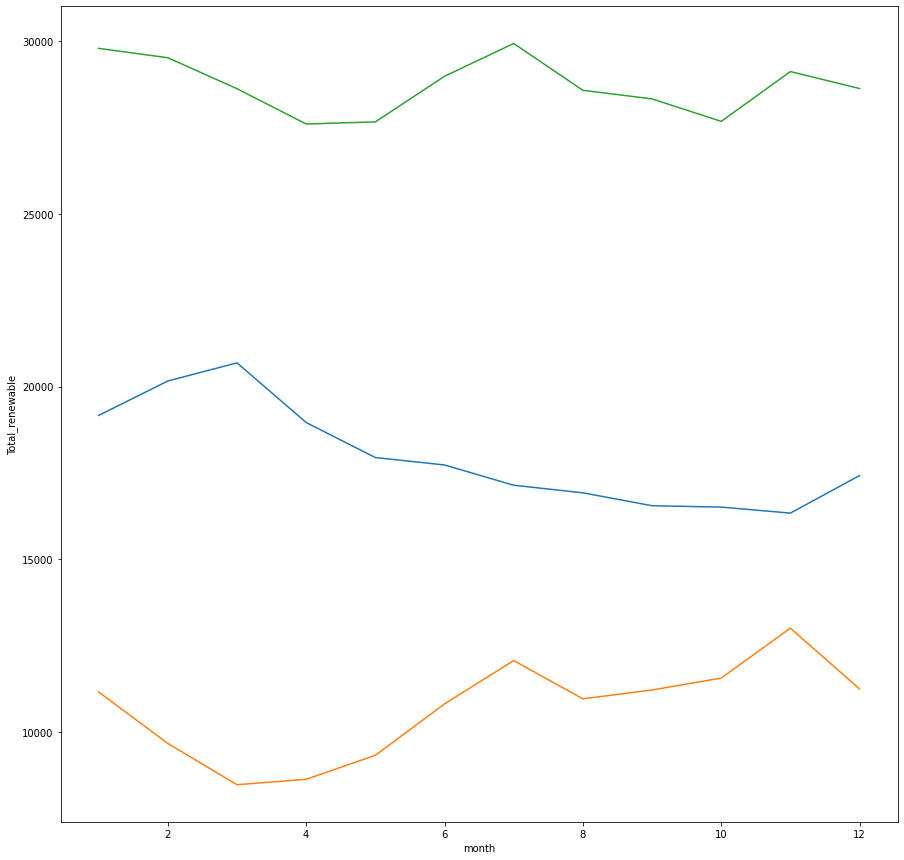

In [69]:
plt.figure(figsize=(15,15))
sns.lineplot(x= 'month',y='Total_renewable',data=month_analysis)
sns.lineplot(x= 'month',y='Total_nonrenewable',data=month_analysis)
sns.lineplot(x= 'month',y='total load actual',data=month_analysis)

In [70]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [71]:
## Prediction model using multivariate analysis

In [77]:
Train_data = energy[['total load actual','total load forecast']]

In [90]:
Train_data = Train_data.reset_index()

In [91]:
Train_data.info() ## no null values as preprocessing already done before

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 35064 non-null  datetime64[ns, UTC]
 1   total load actual    35064 non-null  float64            
 2   total load forecast  35064 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 821.9 KB


In [92]:
### Preparing the data set for prediction (splitting in 0.8 train and 0.2 train)

temp = Train_data.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (28025, 1, 25), Testing set: (6987, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


## Models used 
#### Auto regressive
#### ARMA
#### ARIMA
#### LSTM
#### Neural Prophet

#### Autoregressive (Linear model)

In [94]:
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit()

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


test_prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_prediction = scaler.inverse_transform(test_prediction.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_prediction))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_prediction)))

Test Mean Absolute Error: 3719.921388907444
Test Root Mean Squared Error: 4381.752766425187


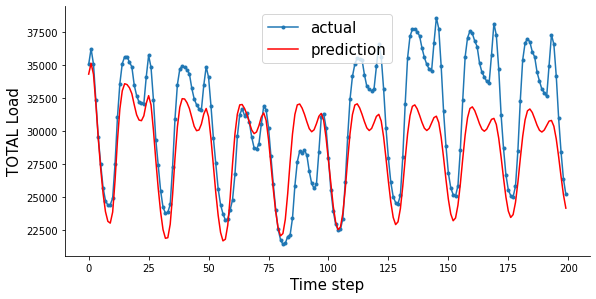

In [98]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_prediction[:idx], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### ARMA

In [100]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)

In [101]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3864.7241259726065
Test Root Mean Squared Error: 4522.223077389229


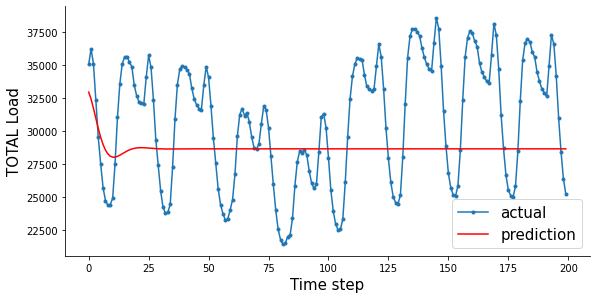

In [102]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

#### ARIMA

In [103]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=False)

In [104]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 10820.698898264887
Test Root Mean Squared Error: 11726.57139448752


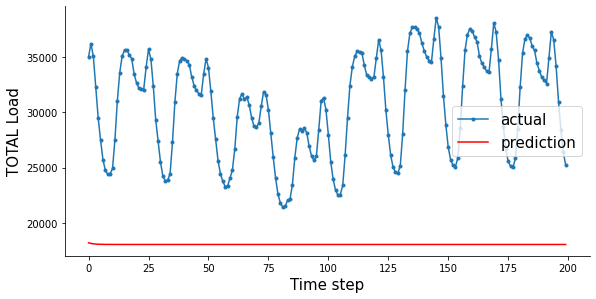

In [105]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#### LSTM

In [108]:
import keras
from keras.models import Sequential
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, trainY, epochs=200, batch_size=70, validation_data=(X_test, testY),verbose=1, shuffle=False)

model.summary()

Epoch 1/200
401/401 [==============================] - 7s 4ms/step - loss: 0.0370 - val_loss: 0.0037
Epoch 2/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 3/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 5/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 7/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 9.7659e-04
Epoch 8/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 9.2667e-04
Epoch 9/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/200
401/401 [==============================] - 1s 3ms/step - loss: 0.0017 

In [112]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([testY])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 356.7001634216685
Train Root Mean Squared Error: 566.0046144314663
Test Mean Absolute Error: 339.84553621876455
Test Root Mean Squared Error: 535.3975618321593


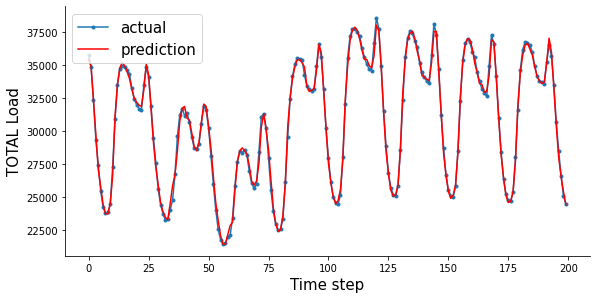

In [113]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#### Neaural prophet

In [115]:
from neuralprophet import NeuralProphet

In [116]:
# NeuralProphet Object
m = NeuralProphet(loss_func="MSE")

In [118]:
energy_final.to_csv('Final_dataframe.csv')